# Etapa 1 | Carregamento, Pré-Processamento Inicial e Divisão dos Dados

In [24]:
# ETAPA 1.0 | Bibliotecas necessárias

import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from typing import List, Dict, Any
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PowerTransformer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ETAPA 1.1 | Carregar dados do Kaggle

def carregarDados(caminhoData: str) -> pd.DataFrame | None:
    """
    Carrega e unifica os arquivos CSV do Kaggle dataset
    ('time_domain', 'heart_rate_non_linear', 'frequency_domain').
    """

    dataframes = {}

    try:
        csvFiles = [f for f in os.listdir(caminhoData) if f.endswith('.csv')]

        if not csvFiles:
            print("ERRO: Nenhum arquivo CSV encontrado.")
            return None

        for fileName in csvFiles:
            fullPath = os.path.join(caminhoData, fileName)
            dfTemp = pd.read_csv(fullPath)

            keyName = fileName.split('.csv')[0]
            dataframes[keyName] = dfTemp
            print(f"✅ Carregado: {keyName} - {dfTemp.shape}")

    except Exception as e:
        print(f"Erro ao carregar: {e}")
        return None

    # Tentando identificar automaticamente quais são time / nonlinear / freq
    possiveisChaves = list(dataframes.keys())

    def buscarChave(texto):
        for key in possiveisChaves:
            if texto in key.lower():
                return key
        return None

    chaveTime = buscarChave('time')
    chaveNonLinear = buscarChave('non')
    chaveFreq = buscarChave('frequency')

    if not all([chaveTime, chaveNonLinear, chaveFreq]):
        print("ERRO: Arquivos esperados não encontrados corretamente.")
        print("Arquivos encontrados:", possiveisChaves)
        return None

    dfMerged = pd.merge(
        dataframes[chaveTime],
        dataframes[chaveNonLinear],
        on='uuid',
        how='inner'
    )

    dfFinal = pd.merge(
        dfMerged,
        dataframes[chaveFreq],
        on='uuid',
        how='inner'
    )

    print(f"\n✅ Dataset unificado com sucesso: {dfFinal.shape}")

    return dfFinal


In [3]:
# ETAPA 1.2 | Transformação inicial dos dados

def transformarDados(df: pd.DataFrame, colunaAlvo: str = 'HR'):
    """
    Separa variáveis preditoras (X) e alvo (Y),
    remove colunas irrelevantes e aplica One-Hot Encoding em 'condition'.
    """

    if df is None:
        print("ERRO: DataFrame vazio.")
        return None, None

    # Colunas que não agregam valor (apenas identificadores)
    colunasParaRemover = ['uuid', 'datasetId']

    # Variável alvo (formato coluna para álgebra linear)
    Y = df[colunaAlvo].values.reshape(-1, 1)

    # Variáveis preditoras (remove alvo + ids)
    X = df.drop(columns=[colunaAlvo] + colunasParaRemover, errors='ignore').copy()

    # One-Hot Encoding para variável categórica 'condition'
    # drop_first=True evita multicolinearidade perfeita
    if 'condition' in X.columns:
        X = pd.get_dummies(X, columns=['condition'], drop_first=True)

    return X, Y

In [4]:
# ETAPA 1.3 | Separação em treino e teste

def dividirTreinoTeste(X, Y, tamanhoTeste=0.2, estadoAleatorio=27):
    """
    Divide os dados em conjunto de treinamento e teste.
    """

    # Separação usando proporção definida (ex: 80% treino / 20% teste)
    XTrain, XTest, YTrain, YTest = train_test_split(
        X, Y, test_size=tamanhoTeste, random_state=estadoAleatorio
    )

    print(f"\n✅ Divisão do Conjunto de Dados: CONCLUÍDA!")
    print(f"   Treino: {XTrain.shape}")
    print(f"   Teste: {XTest.shape}")

    return XTrain, XTest, YTrain, YTest

In [5]:
# ETAPA 1.4 | Pré-processamento dos preditores com Yeo-Johnson seletivo (resumo limpo)

def preProcessarFeatures(XTrainRaw, XTestRaw, skewnessThreshold=1.0):
    """
    Aplica transformação Yeo-Johnson APENAS às features numéricas com |skewness| > threshold.
    Features categóricas (dummies) são apenas padronizadas.
    O ajuste é feito APENAS no conjunto de treino!
    """

    nomesFeatures = XTrainRaw.columns

    # 1. Separar features numéricas e categóricas
    featuresNumericas   = XTrainRaw.select_dtypes(include=[np.number]).columns.tolist()
    featuresCategoricas = XTrainRaw.select_dtypes(exclude=[np.number]).columns.tolist()

    print(f"\n✅ Features numéricas: {len(featuresNumericas)}")
    print(f"📝 Features categóricas (dummies): {len(featuresCategoricas)}")

    # 2. Calcular skewness apenas para features numéricas
    valoresSkewness = np.zeros(len(nomesFeatures))
    featuresParaTransformar = np.zeros(len(nomesFeatures), dtype=bool)

    if len(featuresNumericas) > 0:

        valoresSkew = stats.skew(
            XTrainRaw[featuresNumericas],
            axis=0,
            nan_policy='omit'
        )

        for i, feature in enumerate(nomesFeatures):
            if feature in featuresNumericas:
                indice = featuresNumericas.index(feature)
                valoresSkewness[i] = valoresSkew[indice]
                featuresParaTransformar[i] = abs(valoresSkew[indice]) > skewnessThreshold

        print(f"✅ {featuresParaTransformar.sum()} de {len(featuresNumericas)} features numéricas serão transformadas!")
        print(f"   (Threshold de skewness: ±{skewnessThreshold})")

    # 3. Aplicar Yeo-Johnson apenas às features com alta assimetria
    XTrainTransf = XTrainRaw.copy()
    XTestTransf  = XTestRaw.copy()

    if featuresParaTransformar.any():

        colunasParaTransformar = nomesFeatures[featuresParaTransformar].tolist()

        transformadorPotencia = PowerTransformer(method='yeo-johnson')

        XTrainTransf[colunasParaTransformar] = transformadorPotencia.fit_transform(
            XTrainRaw[colunasParaTransformar]
        )

        XTestTransf[colunasParaTransformar] = transformadorPotencia.transform(
            XTestRaw[colunasParaTransformar]
        )

        print(f"\n✅ Transformação Yeo-Johnson aplicada em:\n {colunasParaTransformar}")

    # 4. Padronização (StandardScaler) para features numéricas
    if len(featuresNumericas) > 0:

        scaler = StandardScaler()

        XTrainEscalado = scaler.fit_transform(XTrainTransf[featuresNumericas])
        XTestEscalado  = scaler.transform(XTestTransf[featuresNumericas])

        XTrain = pd.DataFrame(
            XTrainEscalado,
            columns=featuresNumericas,
            index=XTrainTransf.index
        )

        XTest = pd.DataFrame(
            XTestEscalado,
            columns=featuresNumericas,
            index=XTestTransf.index
        )

        if featuresCategoricas:

            XTrain[featuresCategoricas] = XTrainTransf[featuresCategoricas].values
            XTest[featuresCategoricas]  = XTestTransf[featuresCategoricas].values

            XTrain = XTrain[nomesFeatures]
            XTest  = XTest[nomesFeatures]

        print(f"\n✅ Padronização (StandardScaler) aplicada em {len(featuresNumericas)} features numéricas")
        print(f"✅ {len(featuresCategoricas)} features categóricas mantidas sem padronização")

    else:
        XTrain = XTrainTransf
        XTest  = XTestTransf
        scaler = None

    return XTrain, XTest, scaler, featuresParaTransformar, valoresSkewness

In [19]:
# EXECUÇÃO DA ETAPA 1 | Pipeline Completo

# 1.
path = kagglehub.dataset_download("vinayakshanawad/heart-rate-prediction-to-monitor-stress-level")
caminhoDados = os.path.join(path, 'Train Data', 'Train Data Zip')

df = carregarDados(caminhoDados)

# 2.
X, Y = transformarDados(df, colunaAlvo='HR')

# 3.
XTrainRaw, XTestRaw, YTrain, YTest = dividirTreinoTeste(
    X, Y,
    tamanhoTeste=0.2,
    estadoAleatorio=27
)

# 4.
XTrain, XTest, scaler, featuresParaTransformar, valoresSkewness = preProcessarFeatures(XTrainRaw, XTestRaw, skewnessThreshold=1.0)

Using Colab cache for faster access to the 'heart-rate-prediction-to-monitor-stress-level' dataset.
✅ Carregado: time_domain_features_train - (369289, 20)
✅ Carregado: frequency_domain_features_train - (369289, 12)
✅ Carregado: heart_rate_non_linear_features_train - (369289, 7)

✅ Dataset unificado com sucesso: (369289, 37)

✅ Divisão do Conjunto de Dados: CONCLUÍDA!
   Treino: (295431, 35)
   Teste: (73858, 35)

✅ Features numéricas: 33
📝 Features categóricas (dummies): 2
✅ 21 de 33 features numéricas serão transformadas!
   (Threshold de skewness: ±1.0)

✅ Transformação Yeo-Johnson aplicada em:
 ['SDRR', 'SDRR_RMSSD', 'pNN25', 'pNN50', 'KURT', 'SKEW', 'RMSSD_REL_RR', 'SDSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'SD2', 'sampen', 'VLF', 'LF', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF', 'HF_LF']

✅ Padronização (StandardScaler) aplicada em 33 features numéricas
✅ 2 features categóricas mantidas sem padronização


# Etapa 2 | Modelo de Regressão Penalizado

In [9]:
# ETAPA 2.1 | Regressão Ridge (Implementação do Zero)

class RidgeRegressionDoZero:
    """
    Implementa Regressão Linear Penalizada por L2 (Ridge)
    usando solução analítica:
    W = (XᵀX + λI)⁻¹ XᵀY
    """

    def __init__(self, lambdaParam=1.0):
        self.lambdaParam = lambdaParam
        self.coeficientes = None
        self.intercepto = None

    def adicionarIntercepto(self, X: pd.DataFrame) -> np.ndarray:
        """
        Adiciona uma coluna de 1's para o termo de bias (intercepto)
        """
        XArray = X.values if isinstance(X, pd.DataFrame) else X
        # Verifica e reajusta o shape para garantir que seja 2D, se necessário
        if XArray.ndim == 1:
            XArray = XArray.reshape(-1, 1)

        # Garante que a matriz de preditores esteja em formato float
        XArray = XArray.astype(np.float64)

        return np.c_[np.ones((XArray.shape[0], 1)), XArray]

    def treinar(self, X: pd.DataFrame, Y: np.ndarray):
        """
        Calcula os pesos W usando equações normais com regularização L2
        """
        # Garante que Y seja um vetor coluna (n, 1) e em float64
        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)
        Y = Y.astype(np.float64)

        XComBias = self.adicionarIntercepto(X)
        # XComBias já é float64 graças ao ajuste em adicionarIntercepto!!

        nFeatures = XComBias.shape[1]

        # Matriz identidade (sem penalizar o intercepto)
        # O elemento (0, 0) é zerado para excluir o coeficiente do bias/intercepto da penalidade L2
        matrizIdentidade = np.identity(nFeatures)
        matrizIdentidade[0, 0] = 0

        # Implementação da solução analítica W = (XᵀX + λI)⁻¹ XᵀY
        termoCentral = XComBias.T @ XComBias + self.lambdaParam * matrizIdentidade
        termoDireito = XComBias.T @ Y

        try:
            # np.linalg.solve resolve a equação linear Ax = B, onde x = W.
            W = np.linalg.solve(termoCentral, termoDireito)
            self.intercepto = W[0, 0] # W é (n+1, 1), pegamos o primeiro elemento
            self.coeficientes = W[1:] # Coeficientes dos preditores
        except np.linalg.LinAlgError:
            print(f"ERRO: Matriz singular (λ = {self.lambdaParam})")
            self.coeficientes = None
            self.intercepto = None

    def predizer(self, X: pd.DataFrame) -> np.ndarray:
        """
        Realiza a predição de Y
        """
        if self.intercepto is None or self.coeficientes is None:
            # Retorna NaNs se o modelo não foi treinado ou falhou
            return np.full((X.shape[0], 1), np.nan)

        XComBias = self.adicionarIntercepto(X)

        # Garante que WCompleto seja remontado corretamente (intercepto no topo)
        WCompleto = np.vstack([[self.intercepto], self.coeficientes.reshape(-1, 1)])

        # Predição: XComBias (com 1s) @ WCompleto
        return XComBias @ WCompleto

    def calcularMetricas(self, YReal: np.ndarray, YPred: np.ndarray) -> dict:
        """
        Retorna RMSE e R² entre YReal e YPred
        """

        # Garante que YReal e YPred sejam vetores coluna e float64
        if YReal.ndim == 1:
            YReal = YReal.reshape(-1, 1)
        if YPred.ndim == 1:
            YPred = YPred.reshape(-1, 1)

        YReal = YReal.astype(np.float64)
        YPred = YPred.astype(np.float64)

        if np.isnan(YPred).any():
            return {'rmse': np.nan, 'r2': np.nan}

        # 1. Cálculo do RMSE - Raiz do Erro Quadrático Médio
        # MSE = Média( (YReal - YPred)²)
        mse = np.mean((YReal - YPred) ** 2)
        rmse = np.sqrt(mse)

        # 2. Cálculo do R² - Coeficiente de Determinação
        # Soma Total dos Quadrados
        SST = np.sum((YReal - np.mean(YReal)) ** 2)

        # Soma dos Erros Quadrados
        SSE = np.sum((YReal - YPred) ** 2)

        # R² = 1 - (SSE / SST)
        r2 = 1 - (SSE / SST) if SST != 0 else 1.0

        return {'rmse': rmse, 'r2': r2}

In [20]:
# EXECUÇÃO DA ETAPA 2 | Treinamento e Teste

if 'XTrain' in locals() and 'YTrain' in locals() and 'XTest' in locals() and 'YTest' in locals():

    # Lambda inicial (arbitrário – depois será otimizado!)
    lambdaInicial = 1.0

    modeloRidge = RidgeRegressionDoZero(lambdaParam=lambdaInicial)

    # Treinar modelo!
    modeloRidge.treinar(XTrain, YTrain)

    # Validar se treinamento ocorreu
    if modeloRidge.coeficientes is not None:

        print("\n✅ Treinamento CONCLUÍDO")

        # Correção: O intercepto é um escalar, não precisa do índice [0]
        print(f"   Intercepto (W0): {modeloRidge.intercepto:.4f}")
        print(f"   Nº de coeficientes: {len(modeloRidge.coeficientes)}")

        # --- Impressão dos Coeficientes (β) ---
        print("\n📚 Coeficientes (β) por Feature:")

        feature_names = XTrain.columns
        coefs = modeloRidge.coeficientes.flatten() # Transforma o array (p, 1) em (p,)

        # Criar um DataFrame para visualização mais limpa
        df_coefs = pd.DataFrame({
            'Feature': feature_names,
            'Coeficiente': coefs
        }).sort_values(by='Coeficiente', ascending=False)

        # Imprimir o resultado
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:.4f}'.format):
            print(df_coefs.to_string(index=False))

        # --- Avaliação no conjunto de TREINO ---
        print("\n\n✅ Avaliação no Conjunto de Treino")

        YPredTrain = modeloRidge.predizer(XTrain)
        metricasTrain = modeloRidge.calcularMetricas(YTrain, YPredTrain)

        print(f"   RMSE: {metricasTrain['rmse']:.4f}")
        print(f"   R²  : {metricasTrain['r2']:.4f}")

        # --- Avaliação no conjunto de TESTE ---
        print("\n✅ Avaliação no Conjunto de Teste")

        YPredTeste = modeloRidge.predizer(XTest)
        metricasTeste = modeloRidge.calcularMetricas(YTest, YPredTeste)

        print(f"   RMSE: {metricasTeste['rmse']:.4f}")
        print(f"   R²  : {metricasTeste['r2']:.4f}")

    else:
        print("Falha no treinamento do modelo.")

else:
    print("ERRO: XTrain, XTest, YTrain ou YTest não definidos.")


✅ Treinamento CONCLUÍDO
   Intercepto (W0): 73.8747
   Nº de coeficientes: 35

📚 Coeficientes (β) por Feature:
                Feature  Coeficiente
                   SDRR      23.2187
                  RMSSD      22.6154
                    VLF      14.2559
            SDRR_REL_RR       5.5798
                  HF_NU       4.0699
             SDRR_RMSSD       2.4545
                 HF_PCT       2.2550
                  LF_HF       1.4008
                  pNN25       1.0781
              MEDIAN_RR       0.4345
condition_time pressure       0.2579
            SKEW_REL_RR       0.2506
                   SKEW       0.2506
                  pNN50       0.2274
          MEDIAN_REL_RR       0.1483
    condition_no stress       0.0465
                  LF_NU       0.0098
            MEAN_REL_RR       0.0018
            KURT_REL_RR      -0.3367
                   KURT      -0.3367
                 higuci      -0.6646
            SDSD_REL_RR      -0.6985
           RMSSD_REL_RR      -0.7103


# Etapa 3 | Validação Cruzada K-fold

In [21]:
# ETAPA 3 | Validação Cruzada K-Fold para escolha de λ

def crossValidationRidgeDoZero(X: pd.DataFrame, Y: np.ndarray, lambdaList: List[float], k: int = 5) -> Dict[float, Dict[str, float]]:
    """
    Implementa validação cruzada K-Fold
    """

    results = {}

    # 1. Geração dos índices usando KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=27)

    # 2. Loop principal sobre os lambdas
    for lambdaValue in lambdaList:
        listRMSE = []
        listR2 = []

        # 3. Loop dos folds: Itera sobre os índices gerados pelo KFold
        # idxTreino e idxValidacao são arrays de índices do numpy
        for fold, (idxTreino, idxValidacao) in enumerate(kf.split(X)):

            # Separação dos dados nos índices do fold
            XTrainRaw = X.iloc[idxTreino]
            XValRaw = X.iloc[idxValidacao]
            YTreino = Y[idxTreino]
            YVal = Y[idxValidacao]

            # 1. Fit do scaler APENAS nos dados de TREINO do fold
            muX = XTrainRaw.mean(axis=0)
            sigmaX = XTrainRaw.std(axis=0)

            # Evita divisão por zero
            sigmaX[sigmaX == 0] = 1.0

            # 2. Transformação (aplicar o fit) em Treino e Validação
            XTrain = (XTrainRaw - muX) / sigmaX
            XVal = (XValRaw - muX) / sigmaX

            # Treinamento e Predição

            # Criar e treinar modelo
            modelo = RidgeRegressionDoZero(lambdaParam=lambdaValue)
            modelo.treinar(XTrain, YTreino)

            # Obter predições (usando dados de validação escalados)
            YPred = modelo.predizer(XVal)

            # Calcular métricas
            metrics = modelo.calcularMetricas(YVal, YPred)

            listRMSE.append(metrics['rmse'])
            listR2.append(metrics['r2'])

        # 4. Média dos folds para o lambda atual
        rmseMean = np.mean(listRMSE)
        r2Mean = np.mean(listR2)

        results[lambdaValue] = {
            "rmseMean": rmseMean,
            "r2Mean": r2Mean
        }

        print(f"λ = {lambdaValue:.5f} | RMSE médio = {rmseMean:.4f} | R² médio = {r2Mean:.4f}")

    return results

In [22]:
# EXECUÇÃO DA ETAPA 3 | Otimização de Lambda

# 1. Espaço de busca para Lambda (>= 10 valores)
# Logspace é ideal para cobrir uma ampla faixa de valores, de 0.001 a 1000
lambdaList = np.logspace(-3, 3, 12)

cvResults = crossValidationRidgeDoZero(
    XTrain,
    YTrain,
    lambdaList=lambdaList,
    k=10 # Usando 10 folds para uma estimativa mais robusta
)

λ = 0.00100 | RMSE médio = 1.2997 | R² médio = 0.9842
λ = 0.00351 | RMSE médio = 1.3003 | R² médio = 0.9842
λ = 0.01233 | RMSE médio = 1.3016 | R² médio = 0.9841
λ = 0.04329 | RMSE médio = 1.3070 | R² médio = 0.9840
λ = 0.15199 | RMSE médio = 1.3162 | R² médio = 0.9838
λ = 0.53367 | RMSE médio = 1.3238 | R² médio = 0.9836
λ = 1.87382 | RMSE médio = 1.3287 | R² médio = 0.9835
λ = 6.57933 | RMSE médio = 1.3312 | R² médio = 0.9834
λ = 23.10130 | RMSE médio = 1.3332 | R² médio = 0.9834
λ = 81.11308 | RMSE médio = 1.3412 | R² médio = 0.9832
λ = 284.80359 | RMSE médio = 1.3712 | R² médio = 0.9824
λ = 1000.00000 | RMSE médio = 1.4441 | R² médio = 0.9805


In [23]:
# ETAPA 3.2 | Seleção do Melhor Lambda

# Seleciona o lambda baseado no menor RMSE médio (validação cruzada)
# Utiliza a nova chave 'rmseMean'
lambdaOtimo = min(cvResults, key=lambda l: cvResults[l]['rmseMean'])

print("\nLambda ótimo encontrado:")
print(f"✅ λ* = {lambdaOtimo:.5f}")
# Utiliza as novas chaves 'rmseMean' e 'r2Mean'
print(f"   RMSE médio (CV) = {cvResults[lambdaOtimo]['rmseMean']:.4f}")
print(f"   R² médio  (CV)  = {cvResults[lambdaOtimo]['r2Mean']:.4f}")




# ETAPA 3.3 | Retreinamento com Lambda Ótimo e Avaliação Final

modeloFinal = RidgeRegressionDoZero(lambdaParam=lambdaOtimo)

# Treinar modelo final
modeloFinal.treinar(XTrain, YTrain)

# Verificar se treinamento foi realizado corretamente
if modeloFinal.coeficientes is not None:

    print("\n✅ Retreinamento CONCLUÍDO (λ ótimo)")
    # CORREÇÃO: Intercepto agora é um escalar (float), sem o índice [0]
    print(f"   Intercepto (W0): {modeloFinal.intercepto:.4f}")
    print(f"   Nº de coeficientes: {len(modeloFinal.coeficientes)}")


    # Avaliação no conjunto de treino
    print("\n✅ Avaliação no Conjunto de TREINO (Ajuste)")

    YPredTreino = modeloFinal.predizer(XTrain)
    metricasTreino = modeloFinal.calcularMetricas(YTrain, YPredTreino)

    print(f"   RMSE: {metricasTreino['rmse']:.4f}")
    print(f"   R²  : {metricasTreino['r2']:.4f}")


    # Avaliação no conjunto de teste (Generalização)
    print("\n✅ Avaliação no Conjunto de TESTE (Generalização)")

    YPredTeste = modeloFinal.predizer(XTest)
    metricasTeste = modeloFinal.calcularMetricas(YTest, YPredTeste)

    print(f"   RMSE: {metricasTeste['rmse']:.4f}")
    print(f"   R²  : {metricasTeste['r2']:.4f}")

else:
    print("Falha no retreinamento do modelo final.")


Lambda ótimo encontrado:
✅ λ* = 0.00100
   RMSE médio (CV) = 1.2997
   R² médio  (CV)  = 0.9842

✅ Retreinamento CONCLUÍDO (λ ótimo)
   Intercepto (W0): 73.8892
   Nº de coeficientes: 35

✅ Avaliação no Conjunto de TREINO (Ajuste)
   RMSE: 1.2994
   R²  : 0.9842

✅ Avaliação no Conjunto de TESTE (Generalização)
   RMSE: 1.2938
   R²  : 0.9843


# Etapa Extra | Visualização

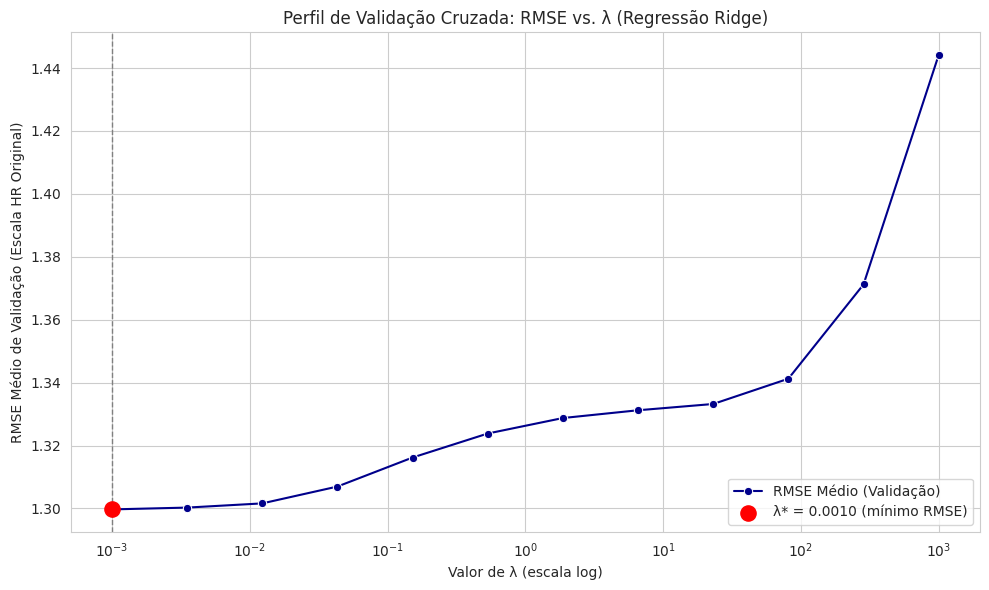

In [27]:
# GRÁFICO 1 | RMSE × λ (trade-off da regularização)

sns.set_style("whitegrid")

# Transformação do dict resultadosCV em DataFrame
dfCv = pd.DataFrame.from_dict(cvResults, orient='index')
dfCv = dfCv.reset_index().rename(columns={'index': 'Lambda'})
dfCv['Lambda'] = dfCv['Lambda'].astype(float)

# Identificando o lambda ótimo
lambda_opt = lambdaOtimo
rmse_opt = dfCv.loc[dfCv['Lambda'] == lambda_opt, 'rmseMean'].iloc[0]

# Plotagem do RMSE Médio versus λ
plt.figure(figsize=(10, 6))

sns.lineplot(
    x='Lambda',
    y='rmseMean',
    data=dfCv,
    marker='o',
    color='darkblue',
    label='RMSE Médio (Validação)'
)

# Marcando o λ ótimo como um ponto vermelho destacado
plt.scatter(
    lambda_opt,
    rmse_opt,
    color='red',
    s=120,
    zorder=5,
    label=f'λ* = {lambda_opt:.4f} (mínimo RMSE)'
)

# Linha vertical tracejada no λ ótimo
plt.axvline(
    x=lambda_opt,
    color='gray',
    linestyle='--',
    linewidth=1
)

plt.xscale('log')  # eixo logarítmico deixando mais bonito e interpretável

plt.title("Perfil de Validação Cruzada: RMSE vs. λ (Regressão Ridge)")
plt.xlabel("Valor de λ (escala log)")
plt.ylabel("RMSE Médio de Validação (Escala HR Original)")

plt.tight_layout()
plt.legend()
plt.show()


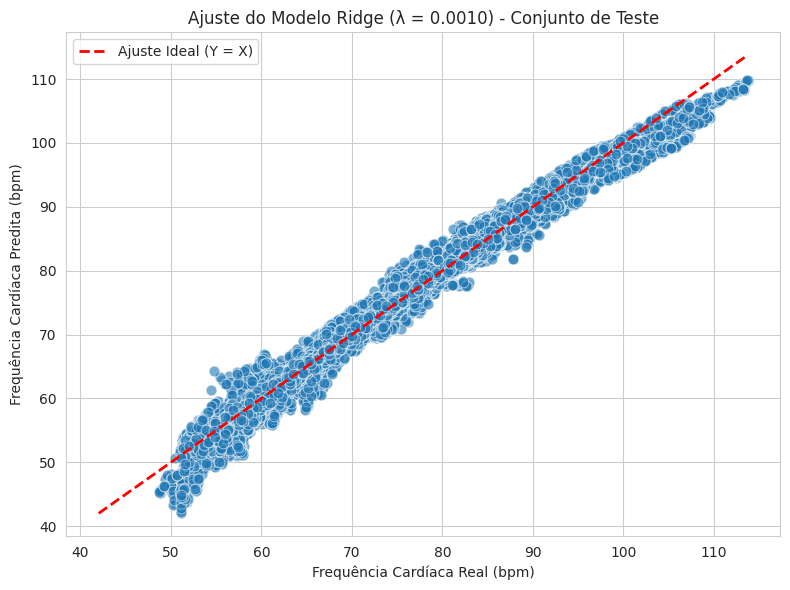

In [29]:
# GRÁFICO 2 | Ajuste Final (y_real vs y_pred)

# Predição usando modelo final
YPredFinal = modeloFinal.predizer(XTest)

# Converter para vetores 1D
YReal = YTest.ravel()
YPred = YPredFinal.ravel()

# Limites para a linha Y = X
minVal = min(YReal.min(), YPred.min())
maxVal = max(YReal.max(), YPred.max())

plt.figure(figsize=(8, 6))

# Scatter plot com seaborn
sns.scatterplot(
    x=YReal,
    y=YPred,
    alpha=0.6,
    s=60
)

# Linha de ajuste ideal
plt.plot(
    [minVal, maxVal],
    [minVal, maxVal],
    color='red',
    linestyle='--',
    linewidth=2,
    label='Ajuste Ideal (Y = X)'
)

plt.title(f'Ajuste do Modelo Ridge (λ = {lambdaOtimo:.4f}) - Conjunto de Teste')
plt.xlabel('Frequência Cardíaca Real (bpm)')
plt.ylabel('Frequência Cardíaca Predita (bpm)')
plt.legend()
plt.tight_layout()
plt.show()

# Etapa 4 | Usando Bibliotecas do Python

In [14]:
# ETAPA 4.1 | Treinamento simples (sem CV) — apenas para referência
# Modelo inicial (antes da CV)
modeloRidge = Ridge(alpha=1.0)
modeloRidge.fit(XTrain, YTrain)

print("\nTreinamento inicial (com biblioteca):")
print(f"   Intercepto: {float(modeloRidge.intercept_):.4f}")
print(f"   Nº coeficientes: {modeloRidge.coef_.shape[1] if modeloRidge.coef_.ndim > 1 else modeloRidge.coef_.shape[0]}")


Treinamento inicial (com biblioteca):
   Intercepto: 73.8747
   Nº coeficientes: 35


/tmp/ipython-input-3413287215.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"   Intercepto: {float(modeloRidge.intercept_):.4f}")


In [15]:
# ETAPA 4.2 | Validação Cruzada K-Fold

def crossValidationRidgeSklearn_CORRIGIDO(X, Y, listaLambda, k=10):
    """
    Validação Cruzada Ridge usando SkLearn
    Para cada fold:
        - scaler é treinado no XTrainFold
        - scaler é aplicado em XTrainFold e XValFold
        - ridge é treinado e avaliado
    """

    results = {}
    kf = KFold(n_splits=k, shuffle=True, random_state=27)

    for lambdaValue in listaLambda:

        listRMSE = []
        listR2 = []

        for fold, (idxTrain, idxVal) in enumerate(kf.split(X)):

            # Separar folds
            XTrainFold_raw = X.iloc[idxTrain]
            XValFold_raw   = X.iloc[idxVal]

            YTrainFold = Y[idxTrain]
            YValFold   = Y[idxVal]

            # Escalonamento dentro do fold (isso evita vazamento!)
            scaler = StandardScaler()

            XTrainFold = scaler.fit_transform(XTrainFold_raw)
            XValFold   = scaler.transform(XValFold_raw)

            # Criar modelo Ridge
            modelo = Ridge(alpha=lambdaValue)

            # Treinar
            modelo.fit(XTrainFold, YTrainFold)

            # Predizer
            YPred = modelo.predict(XValFold)

            # Métricas
            rmse = np.sqrt(mean_squared_error(YValFold, YPred))
            r2   = r2_score(YValFold, YPred)

            listRMSE.append(rmse)
            listR2.append(r2)

        # Médias finais do lambda
        rmseMean = np.mean(listRMSE)
        r2Mean   = np.mean(listR2)

        results[lambdaValue] = {
            "rmseMean": rmseMean,
            "r2Mean": r2Mean
        }

        print(f"λ = {lambdaValue:.5f} | RMSE (CV) = {rmseMean:.4f} | R² (CV) = {r2Mean:.4f}")

    return results

In [16]:
# ETAPA 4.3 | Encontrar λ ótimo

listaLambda = np.logspace(-3, 3, 12)

resultadosCV_sklearn = crossValidationRidgeSklearn_CORRIGIDO(
    XTrain, YTrain,
    listaLambda=listaLambda,
    k=10
)

lambdaOtimo_sklearn = min(resultadosCV_sklearn, key=lambda l: resultadosCV_sklearn[l]['rmseMean']
)

print("\n✅ Lambda ótimo (sklearn, CV sem vazamento):")
print(f"   λ* = {lambdaOtimo_sklearn:.5f}")
print(f"   RMSE médio = {resultadosCV_sklearn[lambdaOtimo_sklearn]['rmseMean']:.4f}")
print(f"   R² médio   = {resultadosCV_sklearn[lambdaOtimo_sklearn]['r2Mean']:.4f}")


# ETAPA 4.4 | Retreinamento FINAL com λ ótimo (sklearn)

# Escalonamento global APENAS no treino
scalerFinal = StandardScaler()
XTrainEscalado_final = scalerFinal.fit_transform(XTrain)
XTestEscalado_final  = scalerFinal.transform(XTest)

modeloFinal_sklearn = Ridge(alpha=lambdaOtimo_sklearn)
modeloFinal_sklearn.fit(XTrainEscalado_final, YTrain)

print("\n✅ Modelo final treinado (sklearn):")
print(f"   Intercepto: {float(modeloFinal_sklearn.intercept_):.4f}")
print(f"   Nº coeficientes: {modeloFinal_sklearn.coef_.shape[0]}")


# Avaliação final
print("\n✅ Avaliação | Sk Learn:")

YPredTrain_final = modeloFinal_sklearn.predict(XTrainEscalado_final)
YPredTest_final  = modeloFinal_sklearn.predict(XTestEscalado_final)

rmseTrain = np.sqrt(mean_squared_error(YTrain, YPredTrain_final))
r2Train   = r2_score(YTrain, YPredTrain_final)

rmseTest = np.sqrt(mean_squared_error(YTest, YPredTest_final))
r2Test   = r2_score(YTest, YPredTest_final)

print(f"   Treino — RMSE: {rmseTrain:.4f} | R²: {r2Train:.4f}")
print(f"   Teste  — RMSE: {rmseTest:.4f} | R²: {r2Test:.4f}")

λ = 0.00100 | RMSE (CV) = 1.2997 | R² (CV) = 0.9842
λ = 0.00351 | RMSE (CV) = 1.3003 | R² (CV) = 0.9842
λ = 0.01233 | RMSE (CV) = 1.3016 | R² (CV) = 0.9841
λ = 0.04329 | RMSE (CV) = 1.3070 | R² (CV) = 0.9840
λ = 0.15199 | RMSE (CV) = 1.3162 | R² (CV) = 0.9838
λ = 0.53367 | RMSE (CV) = 1.3238 | R² (CV) = 0.9836
λ = 1.87382 | RMSE (CV) = 1.3287 | R² (CV) = 0.9835
λ = 6.57933 | RMSE (CV) = 1.3312 | R² (CV) = 0.9834
λ = 23.10130 | RMSE (CV) = 1.3332 | R² (CV) = 0.9834
λ = 81.11308 | RMSE (CV) = 1.3412 | R² (CV) = 0.9832
λ = 284.80359 | RMSE (CV) = 1.3712 | R² (CV) = 0.9824
λ = 1000.00000 | RMSE (CV) = 1.4441 | R² (CV) = 0.9805

✅ Lambda ótimo (sklearn, CV sem vazamento):
   λ* = 0.00100
   RMSE médio = 1.2997
   R² médio   = 0.9842

✅ Modelo final treinado (sklearn):
   Intercepto: 73.9447
   Nº coeficientes: 35

✅ Avaliação | Sk Learn:
   Treino — RMSE: 1.2994 | R²: 0.9842
   Teste  — RMSE: 1.2938 | R²: 0.9843


/tmp/ipython-input-950716188.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"   Intercepto: {float(modeloFinal_sklearn.intercept_):.4f}")
